<a href="https://colab.research.google.com/github/alex-smith-uwec/CS-420/blob/main/Website_Ads_Placement_Optimization_using_Bandit_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

&nbsp;&nbsp;&nbsp;&nbsp;
    Companies placing ads on websites always need to increase the probability that their customers click on them. They perform some methods like A/B testing to compare the performances of different ads in terms of how often people click them. But, they require a lot of human effort and monitoring. Automated selection of ads and performance monitoring is needed.
<br>
&nbsp;&nbsp;&nbsp;&nbsp;
    This project tries to solve this issue using multi-armed bandit Reinforcement Learning. Multi-armed bandit problems deal with situations when an agent has multiple actions to choose from, each action has an unknown rule for reward generation, and the agent tries to learn which actions give higher rewards to maximize its total reward. Here, the agent is the software that automates the ad placement, the actions are to choose different ads, the rewards are the customers' click-through rates of the ads, and the policy is how the agent selects the ads.
<br>
&nbsp;&nbsp;&nbsp;&nbsp;
    Three different simulations of environments are created. The first one is when there is only one webpage with a fixed probability of rewards for each ad (stationary environment). The second one has also one web page but, the probabilities of rewards for each ad change during the experiment time leading to a data drift problem (non-stationary environment). The third one is when there are multiple web pages and each one of them has a different type of customers visiting it with different types of interests which results in different ads are best for different pages, so, ad selection depends on the page (state or context) the user in (contextual bandit).
<br>
&nbsp;&nbsp;&nbsp;&nbsp;
    For each environment, different methods (policies) are used with the learning curves plotted to figure and compare their performances during the time of the experiment, and results are compared. For the first two environments, the agent estimates the action-values by keeping an average of the past rewards taken from each action. For the third environment, action-values are estimated by a shallow neural network that estimates the values for each action given a state of the environment. It acts like DeepMind’s deep Q-network.    

# Import packages and define utility functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import Module, Linear

In [2]:
# This function is given an array and chooses the indexes that has the maximum value of it
def argmaxes(arr):
    arg_maxes = []
    mx = arr[0]

    for i in range(len(arr)):
        if arr[i] > mx:
            mx = arr[i]
            arg_maxes = [i]
        elif arr[i] == mx:
            arg_maxes.append(i)

    return arg_maxes

In [3]:
# Softmax with temperature
def softmax(values, temp=1):
    expo = np.exp(values / temp)
    return expo / np.sum(expo)

In [4]:
# Make one-hot vector
def one_hot(arr_length, index):
    one_hot_array = np.zeros(arr_length)
    one_hot_array[index] = 1
    return one_hot_array

In [5]:
# Given a time-series, calculate exponentially moving average of it
def exp_moving_avg(arr, beta=0.9):
    n = arr.shape[0]
    mov_avg = np.zeros(n)
    mov_avg[0] = (1-beta) * arr[0]
    for i in range(1, n):
        mov_avg[i] = beta * mov_avg[i-1] + (1-beta) * arr[i]
    return mov_avg

In [6]:
# Plot the performance of the learning agent during a period of time
def plot_learning_curves(history_r, history_opt, methods, hyperpara, beta=0.0):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,18))
    fig.subplots_adjust(hspace=0.3)

    for i in range(len(methods)):
        ax1.plot(exp_moving_avg(np.mean(history_r[methods[i] + str(hyp_par[i])], axis=0), beta), label=methods[i] + str(hyp_par[i]));
        ax2.plot(exp_moving_avg(np.mean(history_opt[methods[i] + str(hyp_par[i])], axis=0), beta), label=methods[i] + str(hyp_par[i]));

    ax1.set_title('Average reward per step', fontsize=30);
    ax1.legend(fontsize=15);
    ax1.set_xlabel("Step", fontsize=25);
    ax1.set_ylabel("Average reward", fontsize=25);

    ax2.set_title('Optimal action percent per step', fontsize=30);
    ax2.legend(fontsize=15);
    ax2.set_xlabel("Step", fontsize=25);
    ax2.set_ylabel("Optimal action percent %", fontsize=25);

    ax1.grid(True)
    ax2.grid(True);

# Stationay Environment

In [7]:
class Environment:
    def __init__(self, K=10, shows=10):
        self.K = K #number of actions
        self.shows = shows
        self.update_act_values()

    def update_act_values(self):
        self.probs = np.random.rand(self.K)
        self.optimal_actions = argmaxes(self.probs)

    def get_reward(self, action):
        """
        This function gives a reward for an ad selected by the agent. Every ad has a fixed reward mean that is
        unknown by the agent. It shows the ad to a number of users given by the attribute "shows". The number of
        clicks from them is given as a reward.
        """
        return np.random.binomial(1, self.probs[action], self.shows).sum()

In [8]:
class Agent:
    def __init__(self, K, init_val_est, policy, eps=None, tau=None, alpha=None):
        self.K = K
        self.eps = eps #exploration probability
        self.tau = tau #softmax hyperparameter
        self.alpha = alpha #learning rate
        self.val_est = init_val_est
        self.no_visits = np.zeros(K)
        self.policy = policy

    def select_action(self):
        if self.policy == 'eps_greedy':
            if np.random.rand() < self.eps:
                selected_act = np.random.choice(self.K)
            else:
                selected_act = np.random.choice(argmaxes(self.val_est))
        elif self.policy == 'softmax':
            selected_act = np.random.choice(np.arange(self.K), p=softmax(self.val_est, self.tau))

        self.no_visits[selected_act] += 1
        return selected_act

    def update_act_val(self, action, r):
        if self.alpha == None: #decaying learning rate
            step_size = 1 / self.no_visits[action]
        else: #constant learning rate
            step_size = self.alpha
        self.val_est[action] += step_size * (r - self.val_est[action])

In [9]:
#The experiment runs 1000 times, each time has 1000 steps, the performance is averaged for every step over the runs.
K = 10
n_runs = 1000
steps_per_run = 1000

In [10]:
# compare performances of several values of epsilon-greedy

history_r = {} # history of rewards recieved during a run for each agent
history_opt = {} # history of booleans, if the agent select an optimal action in a step for each agent

methods = ['eps_greedy'] * 4
hyp_par = [0.0, 0.01, 0.05, 0.2]

for i in range(len(methods)):
    history_r[methods[i] + str(hyp_par[i])] = np.zeros((n_runs, steps_per_run))
    history_opt[methods[i] + str(hyp_par[i])] = np.zeros((n_runs, steps_per_run))

    for run in range(n_runs):
        env = Environment(K=K)
        agent = Agent(K=K, init_val_est=np.zeros(K), policy='eps_greedy', eps=hyp_par[i])

        for step in range(steps_per_run):
            a = agent.select_action()
            r = env.get_reward(a)
            agent.update_act_val(a, r)
            history_r[methods[i] + str(hyp_par[i])][run, step] = r
            history_opt[methods[i] + str(hyp_par[i])][run, step] = a in env.optimal_actions

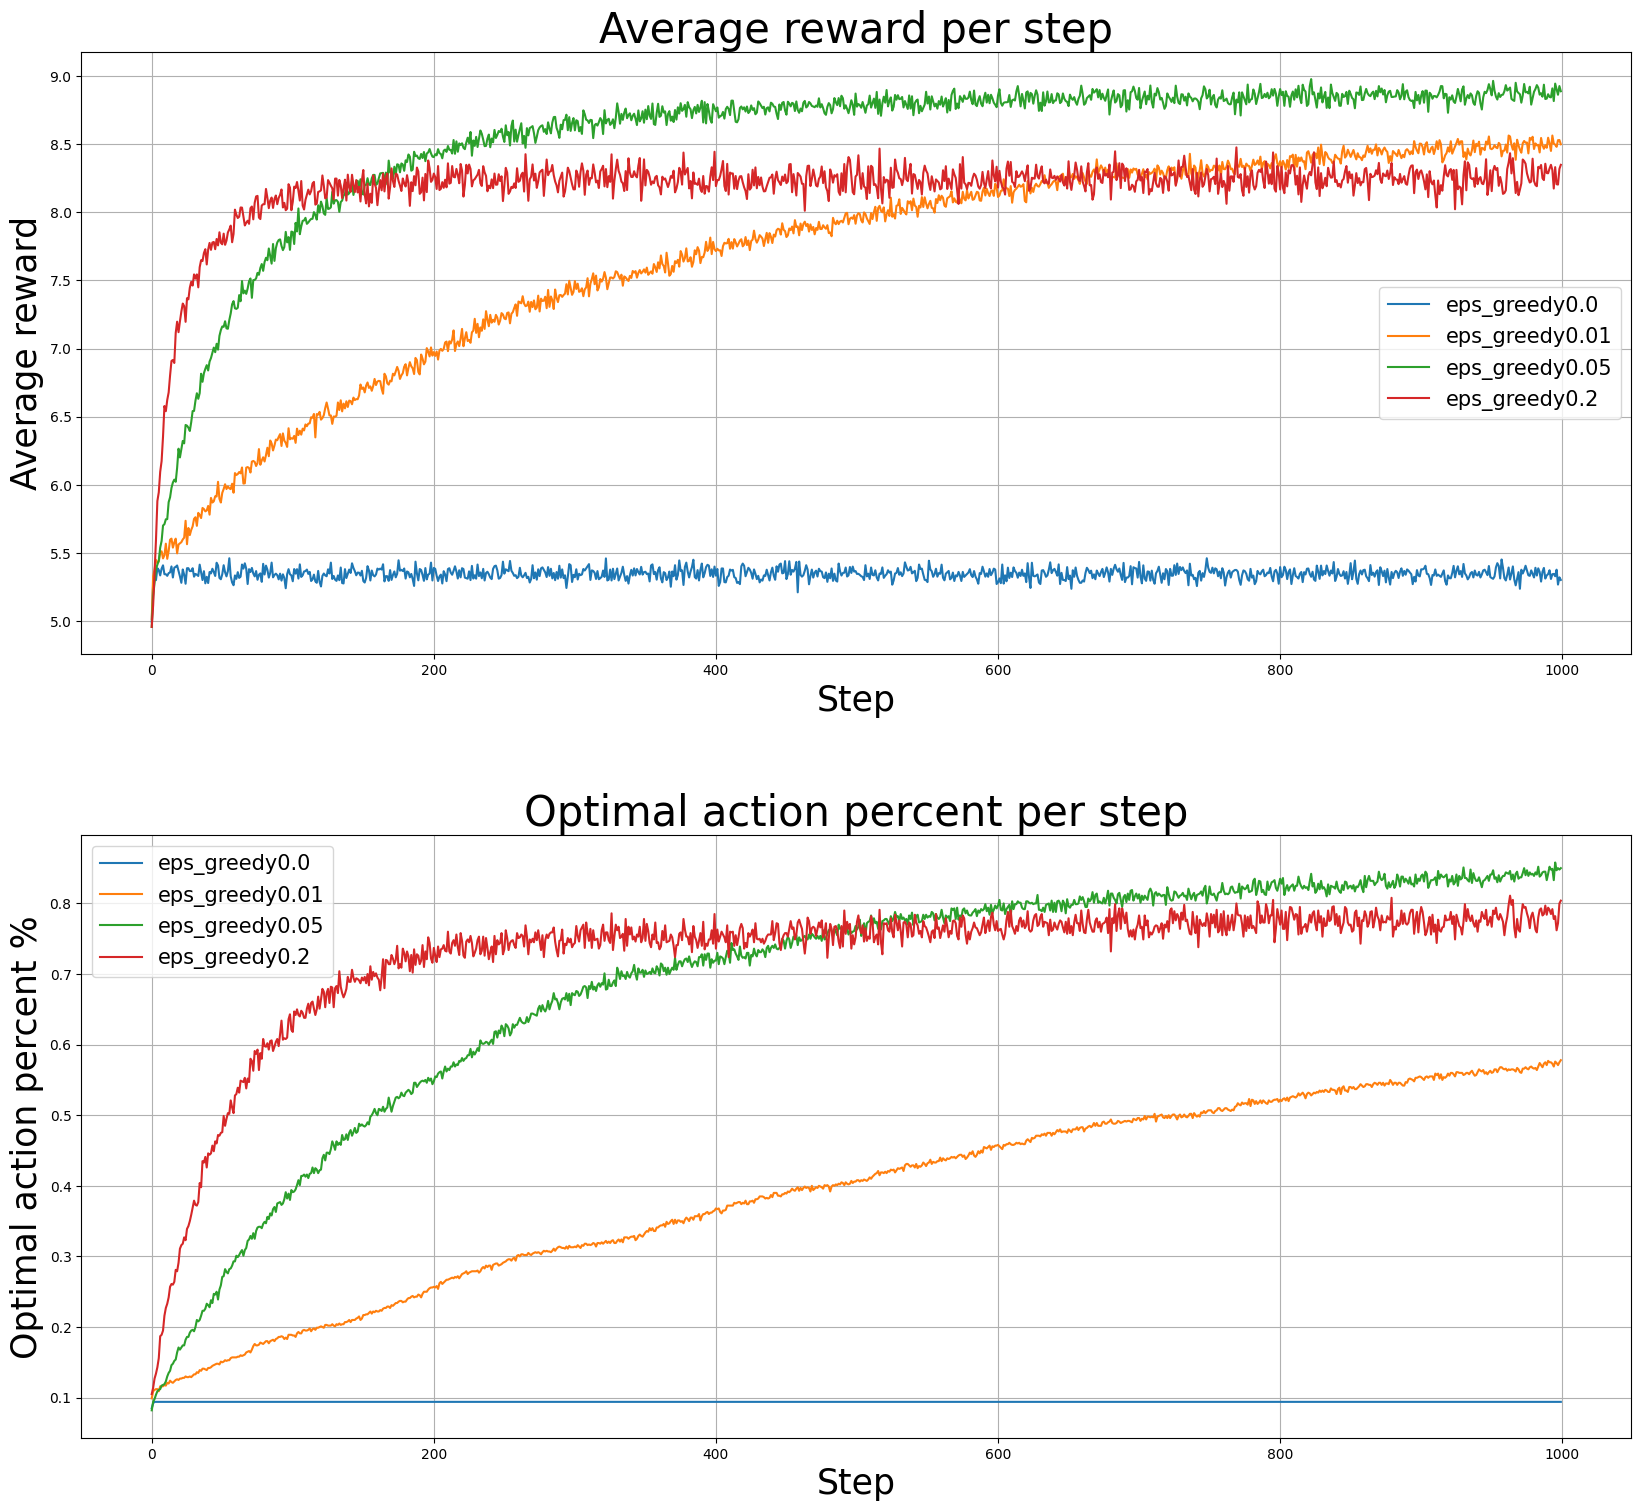

In [11]:
plot_learning_curves(history_r, history_opt, methods, hyp_par)

Increasing the epsilon (exploration rate) leads to finding the best action faster, but, then it takes exploratory steps more leading to selecting sub-optimal actions a lot. A low learning rate selects sub-optimal actions fewer, but, takes more time to converge. With zero epsilon, the agent doesn't explore and keeps selecting whatever action it started with.

In [12]:
# compare performances of several values of temperatures in softmax

history_r = {}
history_opt = {}

methods = ['softmax'] * 5
hyp_par = [0.5, 0.8, 1.0, 1.2, 2.0]

for i in range(len(methods)):
    history_r[methods[i] + str(hyp_par[i])] = np.zeros((n_runs, steps_per_run))
    history_opt[methods[i] + str(hyp_par[i])] = np.zeros((n_runs, steps_per_run))

    for run in range(n_runs):
        env = Environment(K=K)
        agent = Agent(K=K, init_val_est=np.zeros(K), policy='softmax', tau=hyp_par[i])

        for step in range(steps_per_run):
            a = agent.select_action()
            r = env.get_reward(a)
            agent.update_act_val(a, r)
            history_r[methods[i] + str(hyp_par[i])][run, step] = r
            history_opt[methods[i] + str(hyp_par[i])][run, step] = a in env.optimal_actions

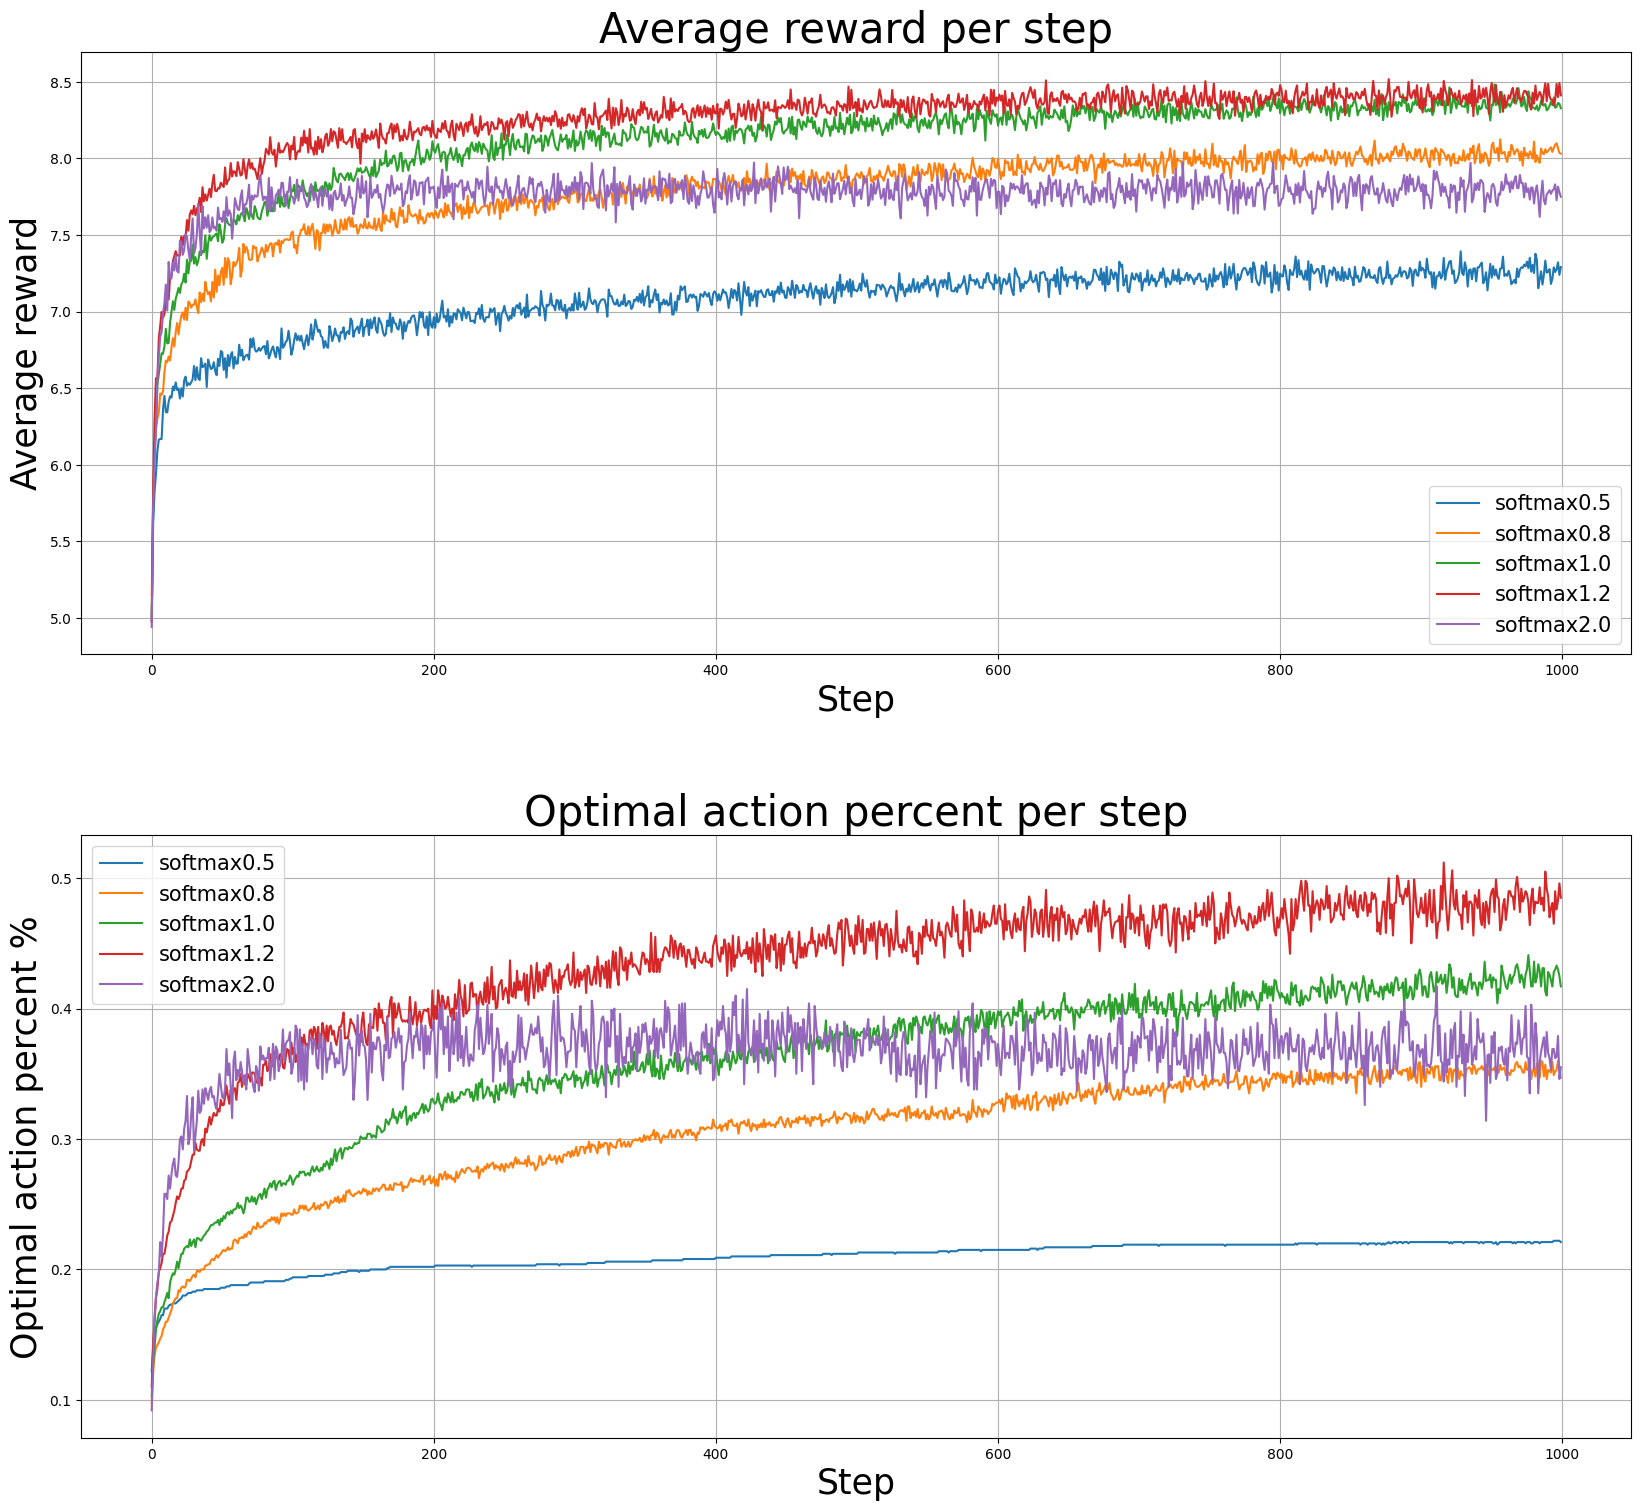

In [13]:
plot_learning_curves(history_r, history_opt, methods, hyp_par)

In [14]:
# compare performances of eps-greedy, softmax, and optimistic initial value

history_r = {}
history_opt = {}

methods = ['eps_greedy', 'softmax', 'opt_init']
hyp_par = [0.05, 1.2, None]

for i in range(len(methods)):
    history_r[methods[i] + str(hyp_par[i])] = np.zeros((n_runs, steps_per_run))
    history_opt[methods[i] + str(hyp_par[i])] = np.zeros((n_runs, steps_per_run))

    for run in range(n_runs):
        env = Environment(K=K)
        if methods[i] == 'eps_greedy':
            agent = Agent(K=K, init_val_est=np.zeros(K), policy='eps_greedy', eps=hyp_par[i])
        elif methods[i] == 'softmax':
            agent = Agent(K=K, init_val_est=np.zeros(K), policy='softmax', tau=hyp_par[i])
        elif methods[i] == 'opt_init':
            agent = Agent(K=K, init_val_est=np.zeros(K) + 20, policy='eps_greedy', eps=0.0)

        for step in range(steps_per_run):
            a = agent.select_action()
            r = env.get_reward(a)
            agent.update_act_val(a, r)
            history_r[methods[i] + str(hyp_par[i])][run, step] = r
            history_opt[methods[i] + str(hyp_par[i])][run, step] = a in env.optimal_actions

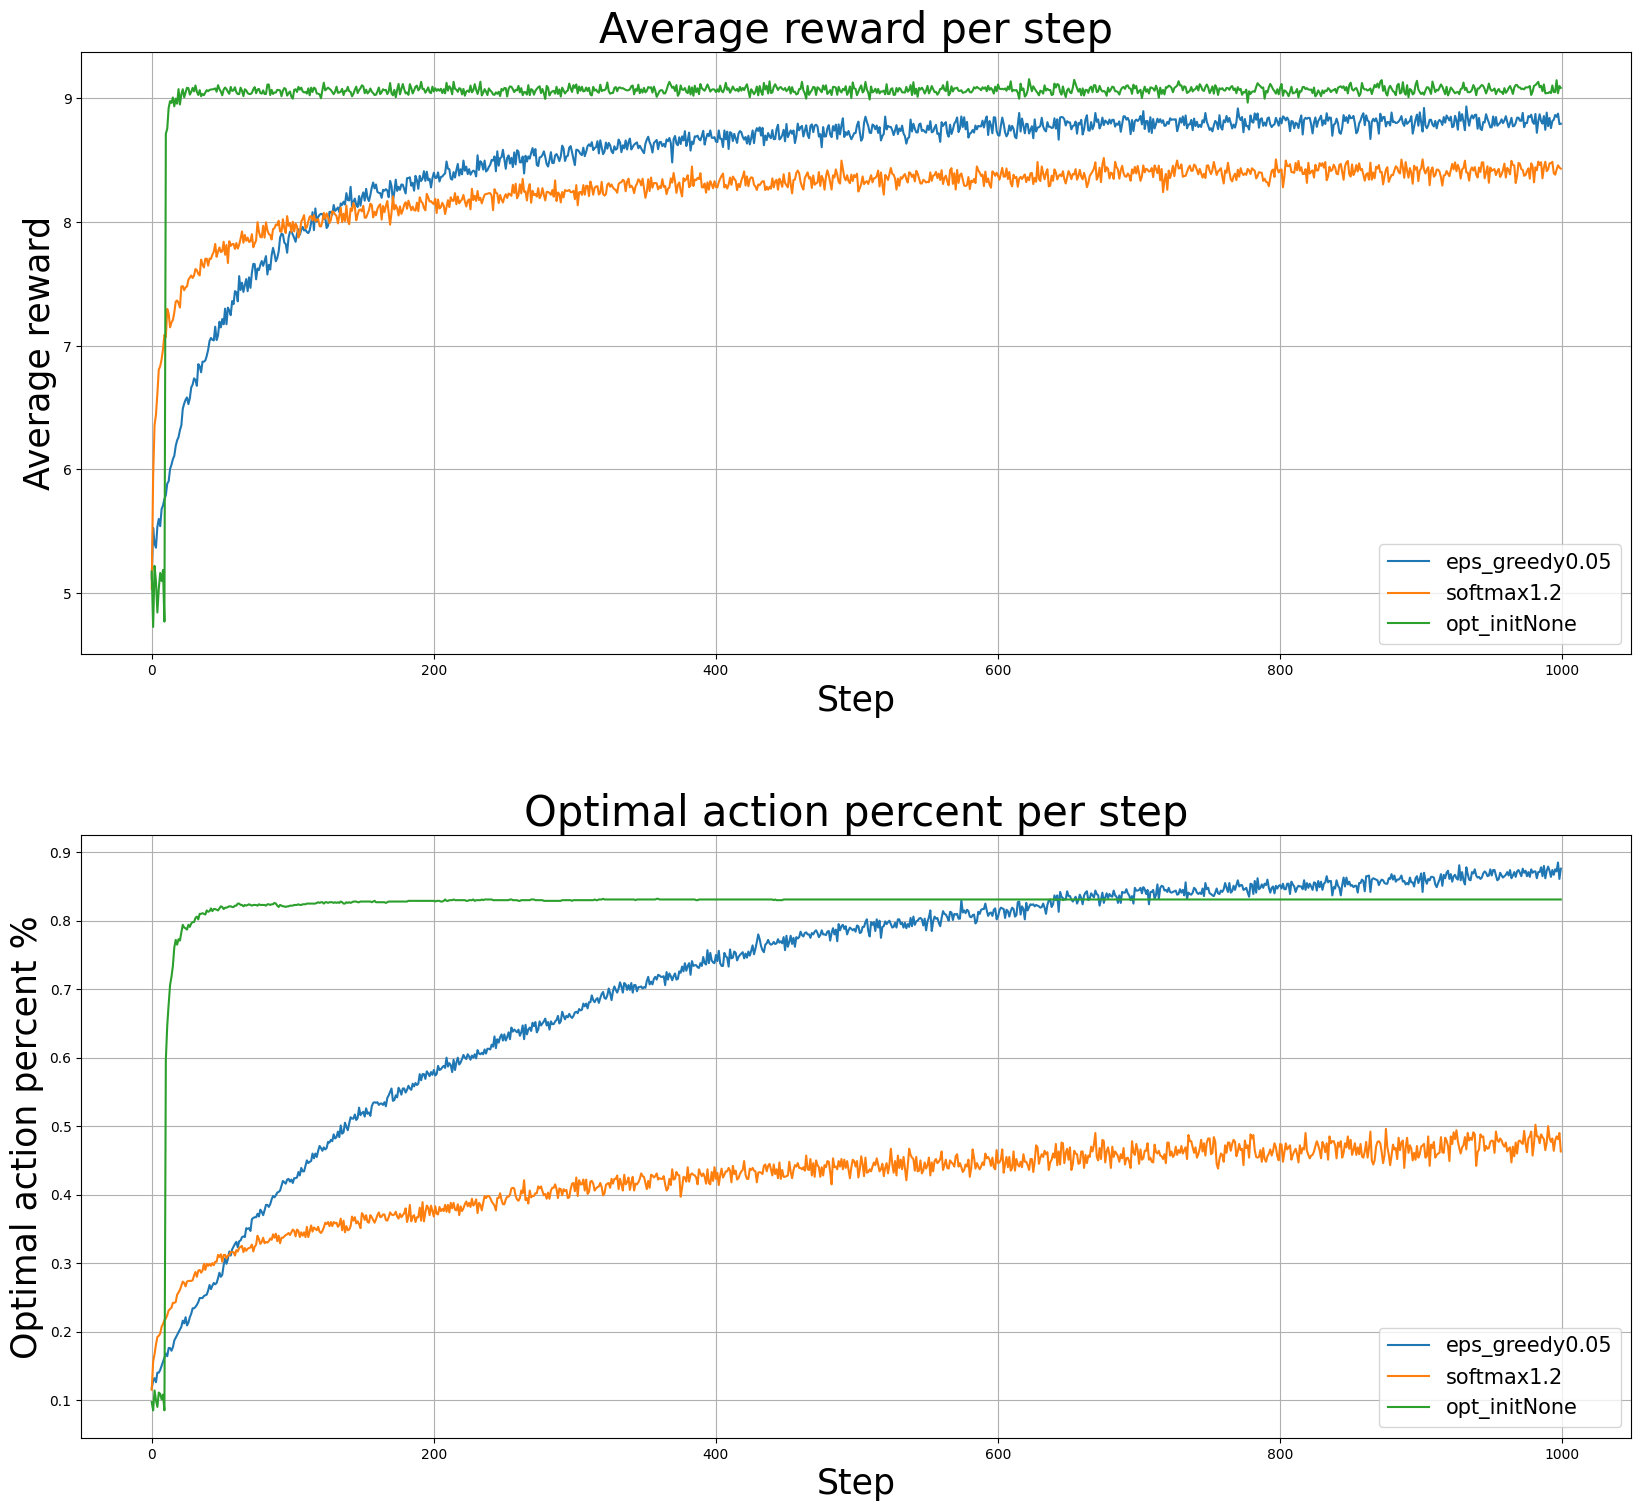

In [15]:
plot_learning_curves(history_r, history_opt, methods, hyp_par)

The epsilon-greedy with optimistic initial value and zero epsilon value method gives better rewards and converges faster than softmax and epsilon-greedy with zero initialization.

# Non-Stationary Environment (Data Drift)

The non-stationary environment is one that changes the reward system it started with during the agent's interaction. If the appropriate ad changes during time, this is non-stationary. Here, the experiment compares between using constant learning rate and using decaying learning rate in estimating action-values in an epsilon-greedy agent.<br>
<b>Note:</b> optimistic initial value method shouldn't be applied here because it tends to find the optimal action early and use during the remainig time steps without exploring more.

In [16]:
K = 10
n_runs = 1000
steps_per_run = 10000

In [17]:
# compare performances of eps-greedy on non-stationary environments between canstant and decaying learning rate
history_r = {}
history_opt = {}

methods = ['const_lr', 'dec_lr']
hyp_par = [0.1, None]

for i in range(len(methods)):
    history_r[methods[i] + str(hyp_par[i])] = np.zeros((n_runs, steps_per_run))
    history_opt[methods[i] + str(hyp_par[i])] = np.zeros((n_runs, steps_per_run))

    for run in range(n_runs):
        env = Environment(K=K)
        agent = Agent(K=K, init_val_est=np.zeros(K), policy='eps_greedy', eps=0.05, alpha=hyp_par[i])

        for step in range(steps_per_run):
            a = agent.select_action()
            r = env.get_reward(a)
            agent.update_act_val(a, r)
            history_r[methods[i] + str(hyp_par[i])][run, step] = r
            history_opt[methods[i] + str(hyp_par[i])][run, step] = a in env.optimal_actions

            if step == steps_per_run / 2:
                env.update_act_values()

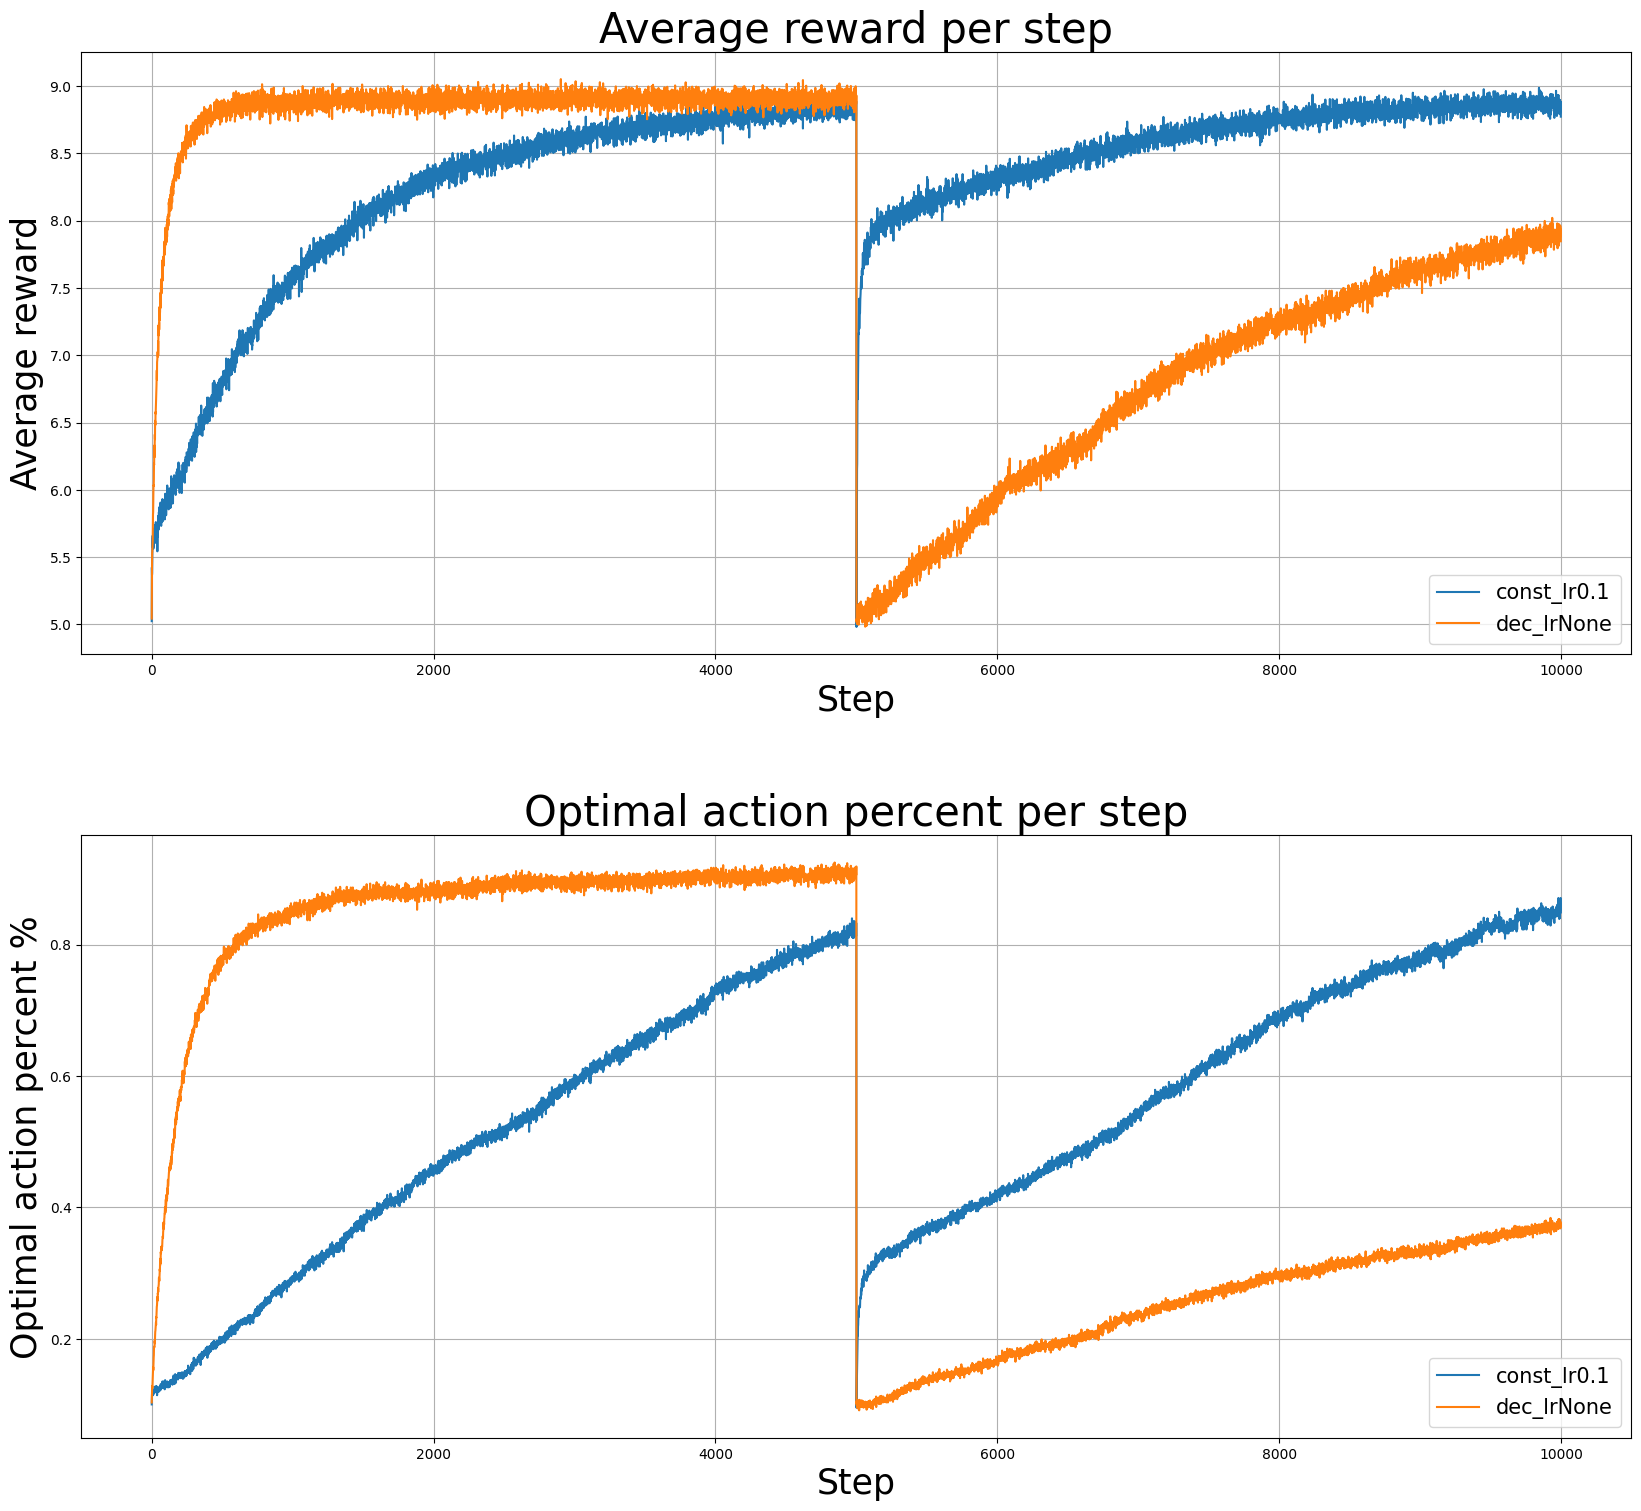

In [18]:
plot_learning_curves(history_r, history_opt, methods, hyp_par)

The decaying learning rate is faster in finding how to increase reward, but, the constant learning rate adapts faster when the environment's reward system changes. Because, the constant learning rate give higher weight to the recent rewards, while the decaying rate treates them all equally.  

# Contextual Bandits

&nbsp;&nbsp;&nbsp;&nbsp;
Previous experiments assume that there is only one state of the environment and they tried to maximize rewards in this state. But, usually, the environment contains many states with different action values for different states. Here, the agent needs to learn to deal with each state separately from other states.
<br>&nbsp;&nbsp;&nbsp;&nbsp;
In this experiment, action-value for each state is estimated with a neural network, and the agent decides which action to choose given the output of the neural network.

In [19]:
class Context_Environment:
    def __init__(self, n_states, n_actions, shows=10):
        self.n_states = n_states
        self.n_actions = n_actions
        self.probs = np.random.rand(n_states, n_actions)
        self.shows = shows
        self.optimal_actions = [None] * n_states
        for i in range(n_states):
            self.optimal_actions[i] = argmaxes(self.probs[i])
        self.update_state()

    def update_state(self):
        self.curr_state = np.random.randint(0, self.n_states)

    def get_reward(self, action):
        return np.random.binomial(1, self.probs[self.curr_state, action], self.shows).sum()

In [20]:
class NN_Agent(Module):
    def __init__(self, n_states, n_actions, n_hidden, policy, eps=None, tau=None, alpha=None):
        super(NN_Agent, self).__init__()
        self.n_states = n_states
        self.n_actions = n_actions
        self.eps = eps
        self.tau = tau
        self.alpha = alpha
        self.policy = policy
        self.fc1 = Linear(n_states, n_hidden)
        self.fc2 = Linear(n_hidden, n_actions)

    def forward(self, X):
        X = self.fc1(X)
        X = torch.nn.ReLU()(X)
        X = self.fc2(X)
        return X

    def select_action(self, curr_state):
        self.val_est = self.forward(torch.Tensor(one_hot(self.n_states, curr_state)))
        if self.policy == 'eps_greedy':
            if np.random.rand() < self.eps:
                selected_act = np.random.choice(self.n_actions)
            else:
                selected_act = np.random.choice(argmaxes(self.val_est.data.numpy()))
        elif self.policy == 'softmax':
            selected_act = np.random.choice(self.n_actions, p=softmax(self.val_est.data.numpy(), self.tau))

        return selected_act

In [21]:
n_states = 20
n_actions = 10
n_hidden = 100
n_runs = 30
steps_per_run = 10000
lr = 0.01
loss_fn = torch.nn.MSELoss()

In [33]:
# history_r = {}
# history_opt = {}

# methods = ['softmax', 'eps_greedy']
# hyp_par = [1.0, 0.1]

# for i in range(len(methods)):
#     history_r[methods[i] + str(hyp_par[i])] = np.zeros((n_runs, steps_per_run))
#     history_opt[methods[i] + str(hyp_par[i])] = np.zeros((n_runs, steps_per_run))

#     for run in range(n_runs):
#         env = Context_Environment(n_states=n_states, n_actions=n_actions)
#         opt_actions = env.optimal_actions

#         if methods[i] == 'eps_greedy':
#             agent = NN_Agent(n_states=n_states, n_actions=n_actions, n_hidden = n_hidden, policy='eps_greedy', eps=hyp_par[i])
#         elif methods[i] == 'softmax':
#             agent = NN_Agent(n_states=n_states, n_actions=n_actions, n_hidden = n_hidden, policy='softmax', tau=hyp_par[i])

#         optimizer = torch.optim.Adam(agent.parameters(), lr=lr)

#         for step in range(steps_per_run):
#             curr_state = env.curr_state
#             a = agent.select_action(curr_state)
#             r = env.get_reward(a)
#             pred = agent.val_est
#             all_r = pred.data.numpy().copy()
#             all_r[a] = r
#             all_r = torch.Tensor(all_r)
#             loss = loss_fn(pred, all_r)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             env.update_state()
#             history_r[methods[i] + str(hyp_par[i])][run, step] = r
#             history_opt[methods[i] + str(hyp_par[i])][run, step] = a in opt_actions[curr_state]

history_r = {}
history_opt = {}

methods = ['softmax', 'eps_greedy']
hyp_par = [1.0, 0.1]

for i in range(len(methods)):
    history_r[methods[i] + str(hyp_par[i])] = np.zeros((n_runs, steps_per_run))
    history_opt[methods[i] + str(hyp_par[i])] = np.zeros((n_runs, steps_per_run))

    for run in range(n_runs):
        env = Context_Environment(n_states=n_states, n_actions=n_actions)
        opt_actions = env.optimal_actions

        if methods[i] == 'eps_greedy':
            eps_greedy_agent = NN_Agent(n_states=n_states, n_actions=n_actions, n_hidden=n_hidden, policy='eps_greedy', eps=hyp_par[i])
            current_agent = eps_greedy_agent  # Assigning the current agent
        elif methods[i] == 'softmax':
            softmax_agent = NN_Agent(n_states=n_states, n_actions=n_actions, n_hidden=n_hidden, policy='softmax', tau=hyp_par[i])
            current_agent = softmax_agent  # Assigning the current agent

        optimizer = torch.optim.Adam(current_agent.parameters(), lr=lr)

        for step in range(steps_per_run):
            curr_state = env.curr_state
            a = current_agent.select_action(curr_state)  # Using current_agent for action selection
            r = env.get_reward(a)
            pred = current_agent.val_est
            all_r = pred.data.numpy().copy()
            all_r[a] = r
            all_r = torch.Tensor(all_r)
            loss = loss_fn(pred, all_r)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            env.update_state()
            history_r[methods[i] + str(hyp_par[i])][run, step] = r
            history_opt[methods[i] + str(hyp_par[i])][run, step] = a in opt_actions[curr_state]


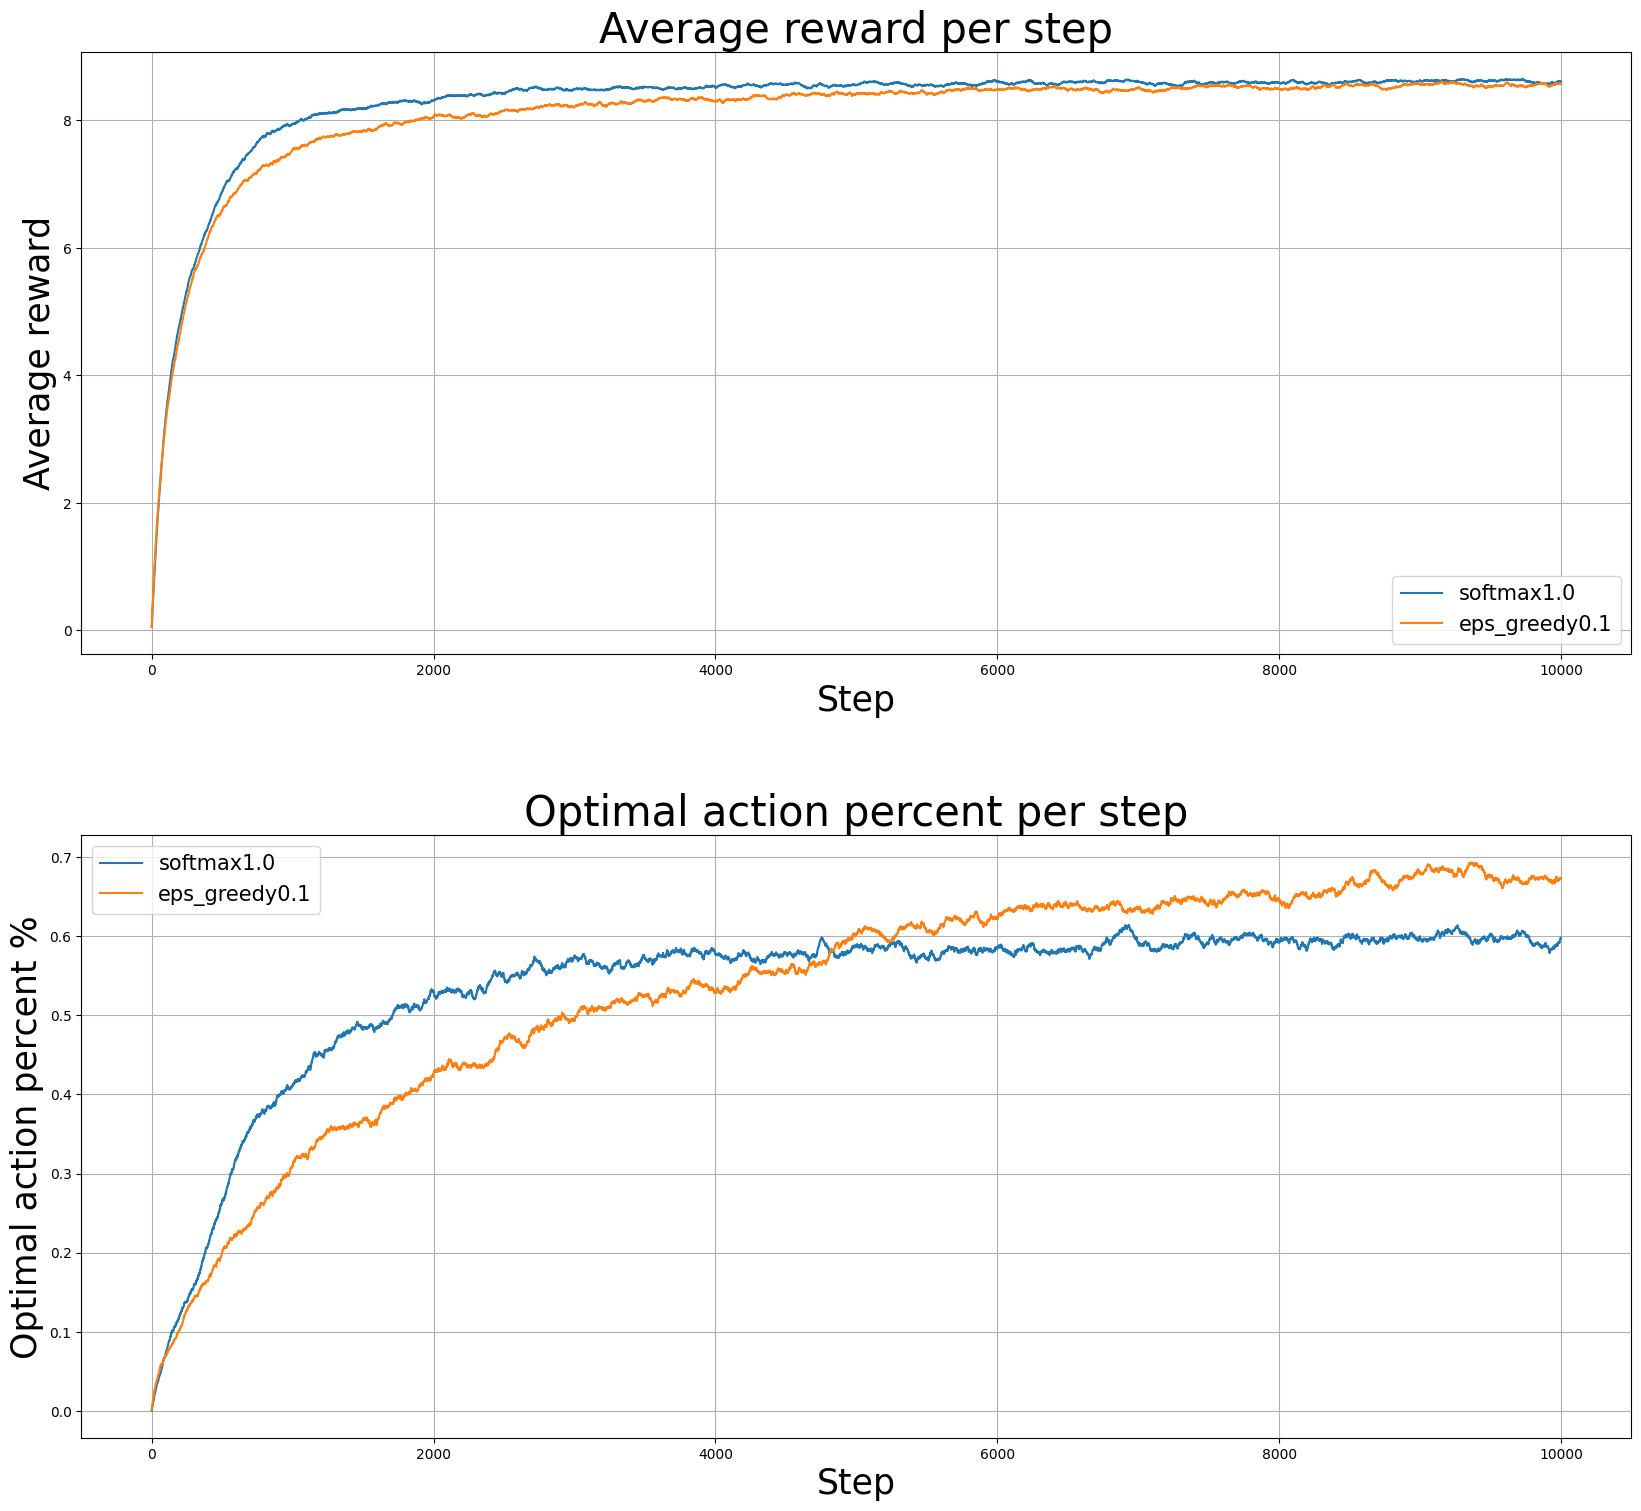

In [34]:
plot_learning_curves(history_r, history_opt, methods, hyp_par, beta=0.99)

Softmax starts faster. But, after some time, eps-greedy approaches it in terms of average reward and exceeds it in terms of selecting the optimal action.

In [43]:
# Define the state index you want to evaluate
state_index = 4  # Replace 4 with the actual index of your state

# Ensure n_states is defined and corresponds to the total number of states
n_states = 20  # Replace 20 with your actual number of states

one_hot_state = torch.zeros([n_states])
one_hot_state[state_index] = 1  # Set the element corresponding to the state_index to 1

# Assuming 'agent' is your trained NN_Agent instance
action_values = softmax_agent.forward(one_hot_state)
best_action = torch.argmax(action_values).item()

# Now best_action contains the index of the predicted best action for the given state
best_action


7

In [41]:
import pandas as pds

# Initialize a list to store the state, eps_greedy action, and softmax action
comparisons = []

# Iterate through each state
for state_index in range(n_states):

    # Get the action for eps_greedy_agent
    eps_greedy_action = eps_greedy_agent.select_action(state_index)

    # Get the action for softmax_agent
    softmax_action = softmax_agent.select_action(state_index)

    # Append the state and actions to the comparisons list
    comparisons.append([state_index, eps_greedy_action, softmax_action])

# Create a DataFrame from the comparisons list
df = pd.DataFrame(comparisons, columns=['State', 'Eps_Greedy_Action', 'Softmax_Action'])


In [42]:
df

,State,Eps_Greedy_Action,Softmax_Action
0,0,2,4
1,1,5,1
2,2,4,5
3,3,0,4
4,4,2,7
5,5,4,1
6,6,8,8
7,7,4,7
8,8,3,6
9,9,5,1
